In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_data= pd.read_csv("preprocessed_european_comments.csv")

In [3]:
train_data.head()

,Unnamed: 0,body,Subjectivity,Polarity,Analysis
0,0,"woman claims said insults, bystanders didnt. t...",0.843750,-0.322917,Negative
1,1,turkey doesn't know balkans.,0.000000,0.000000,Neutral
2,2,lot talk turkey,0.000000,0.000000,Neutral
3,3,don't like ruling party turkey. it's turkish p...,0.000000,0.000000,Neutral
4,4,create confusion absolute numbers. ~0.01 popul...,0.423384,-0.020833,Negative


In [4]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['body'].apply(lambda x:len(str(x).split())) 

In [5]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Positive    34026
Negative    21331
Neutral     16463
Name: Analysis, dtype: int64
Total comments:  71820


In [6]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :3263


In [8]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['body'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[75, 127, 526, 2725]]


In [9]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['body'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [10]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-10-52717cdf9361>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-52717cdf9361>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [11]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [12]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [13]:
#train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
#test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [14]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

57259    Negative
14501    Positive
22125     Neutral
7844     Positive
30747    Negative
18970    Positive
13870     Neutral
56432    Negative
51771    Negative
63354    Positive
Name: Analysis, dtype: object
Text to number
[0 2 1 2 0 2 1 0 0 2]
Number to category
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [22]:
# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005)))     

#model.add(tf.keras.layers.LSTM(64, dropout=0.1, return_sequences=True))
#model.add(tf.keras.layers.Dense(3))

#model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                            kernel_regularizer=regularizers.l2(0.005),\
                                                            bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(3,activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=["CategoricalAccuracy", AUC(name='auc')])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 64)           1920000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256, 64)           33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                

In [23]:
x_test.shape

(7182, 256)

In [24]:
test_labels.shape

(7182, 3)

In [25]:
# Training model
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(x_train,
                    train_labels,
                    epochs= epochs,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
2020/2020 [==============================] - 340s 167ms/step - loss: 1.2532 - categorical_accuracy: 0.5736 - auc: 0.7715 - val_loss: 0.7896 - val_categorical_accuracy: 0.6763 - val_auc: 0.8730
Epoch 2/10
2020/2020 [==============================] - 350s 173ms/step - loss: 0.8423 - categorical_accuracy: 0.6581 - auc: 0.8539 - val_loss: 0.7677 - val_categorical_accuracy: 0.6845 - val_auc: 0.8875
Epoch 3/10
2020/2020 [==============================] - 338s 168ms/step - loss: 0.7846 - categorical_accuracy: 0.6723 - auc: 0.8735 - val_loss: 0.7559 - val_categorical_accuracy: 0.7605 - val_auc: 0.9026
Epoch 4/10
2020/2020 [==============================] - 339s 168ms/step - loss: 0.7554 - categorical_accuracy: 0.7077 - auc: 0.8866 - val_loss: 0.6847 - val_categorical_accuracy: 0.7925 - val_auc: 0.9224
Epoch 5/10
2020/2020 [==============================] - 356s 176ms/step - loss: 0.7418 - categorical_accuracy: 0.7295 - auc: 0.8958 - val_loss: 0.6594 - val_categorical_accuracy: 0.804

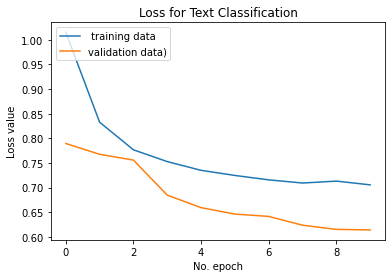

In [26]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

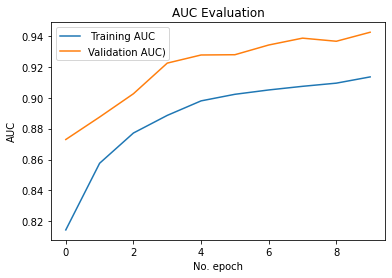

In [27]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [28]:
X_test

58787    old news based kktc’s president said. afaik (o...
16737    words "turkey doesn't want follow unclos inven...
27353       thought turk guys ok posts turkey /r/europe :d
62209    true. tides shift comes time slaughtered disag...
40789    thanks do, mate. mission seek help reddit prev...
                               ...                        
24478    didn't send them, let go. huge difference lett...
30753    [so, addresses "what simply refuse import will...
9977     turkey arrested right? highest number journali...
7303     doesn't story baltics analogous cyprus. popula...
32862    isn't co2 tax, alternative bar lpg. turkey hug...
Name: body, Length: 7182, dtype: object

In [31]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-31-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [32]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples


array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [33]:
y_test.shape
y_test

58787    Negative
16737    Positive
27353    Positive
62209    Negative
40789    Positive
           ...   
24478    Negative
30753    Positive
9977     Positive
7303     Positive
32862    Positive
Name: Analysis, Length: 7182, dtype: object

In [34]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

In [35]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       0.81      0.90      0.86      3426
    Negative       0.76      0.67      0.71      2097
     Neutral       0.95      0.89      0.92      1659

    accuracy                           0.83      7182
   macro avg       0.84      0.82      0.83      7182
weighted avg       0.83      0.83      0.83      7182

